# Predicting Future Product Demand
## Adrian Sandoval-Vargas
### Business Questions
1. What is the monthly demand by Product Category and the Products in the most demanded category?
2. What are the top products across all product categories?
3. Is there seasonal trends?  

### Kaggle Dataset:
**Context**  
The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

**Content**  
Historical Product Demand.csv - CSV data file containing product demand for encoded product id's

**Acknowledgements**  
This dataset is all real-life data and products/warehouse and category information encoded.

**Inspiration**  
Is it possible to make forecasts for thousands of products (some of them are highly variable in terms of monthly demand) for the month after next?  
* https://www.kaggle.com/felixzhao/productdemandforecasting 

#### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from sklearn.model_selection import train_test_split
import datetime
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import seed
from tensorflow.random import set_seed
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

#### LOAD THE DATASET
Set the seed for the project

In [2]:
set_seed(10)
seed(10)
df = pd.read_csv('Historical Product Demand.csv')

#### Dataset Information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [4]:
df.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


### Data Preprocessing

In [5]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

#### Determining whether to drop or impute missing Date values
A possible fix is to compute the time delta of n-1 and n+1 dates of missing value and put the date between those two dates.  
What if there are no dates in n-1 or n+1?

In [6]:
indexes = df[df['Date'].isnull()].index.tolist() #gathers the indexes where the Null values occur and puts them into a list
dif = np.diff(indexes) #finds the difference between the indexes and returns a list
prev = 0 #previous index
possible_fix = 0 #number of date fields we can fix
# Finds the difference between the indexes
# If previous index is not a 1, this means that the null values are not next to eachother, thus a possible date fix can be made.
for i in range(len(dif)):
    if prev == i:
        pass
    else:
        if dif[prev] != 1:
            possible_fix += 1
        prev = i
possible_fix

print(f'Possible_Fix to Null Ratio: {possible_fix/len(indexes):.2f}')
print(f'Null to whole dataset Ratio: {len(indexes)/df.shape[0]:.2f}')

Possible_Fix to Null Ratio: 0.02
Null to whole dataset Ratio: 0.01


#### Since the possible fix ratio is 0.02% and the number of null values in the whole dataset is 0.01%. We can drop the data from the dataframe.

In [7]:
# Dropping Null values from dataframe
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1037331,Product_1791,Whse_J,Category_006,2016/4/27,1000
1037332,Product_1974,Whse_J,Category_006,2016/4/27,1
1037333,Product_1787,Whse_J,Category_006,2016/4/28,2500
1037334,Product_0901,Whse_J,Category_023,2016/10/7,50


In [8]:
df.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [9]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [10]:
# Sort the values by date
df = df.sort_values('Date')
df.head()

#### As you can see there are parenthesis in order demand that we need to fix

In [ ]:
# Replaces the parenthesis and converts the string to int
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df['Order_Demand'] = df['Order_Demand'].astype('int64')
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011/1/8,2
131429,Product_0412,Whse_S,Category_007,2011/10/20,2
131426,Product_0125,Whse_S,Category_011,2011/10/20,2
75193,Product_0642,Whse_C,Category_019,2011/10/31,3
131026,Product_2137,Whse_S,Category_009,2011/11/18,25


#### Copy DF for visuals

In [ ]:
vs_df = df.copy()
vs_df['Date'] = pd.to_datetime(vs_df['Date'])
vs_df['Date:year'] = vs_df['Date'].dt.year
vs_df['Date:month'] = vs_df['Date'].dt.month

### Q1: What is the monthly demand by Product Category and the Products in the most demanded category?

Lets start by creating a pivot table with the X-axis being the date, the features being the Categories, and the Y-axis will be monthly product demand.

In [ ]:
cat_demand = pd.pivot_table(vs_df,index=["Date"],values=["Order_Demand"],columns=["Product_Category"],aggfunc=np.sum)
cat_demand.columns = cat_demand.columns.droplevel(0)
cat_demand = cat_demand.resample('M').sum() # Resampling the data on monthly basis 
cat_demand.index.freq = "M" # Setting datetime frequency to Month
ax = cat_demand.plot(figsize = (20,6))
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left') #adjusts the legend outside the graph
ax.set_ylabel('Order Demand in Tens of Millions')
# ax.set_ylim(0, 90000000)

Text(0, 0.5, 'Order Demand in Tens of Millions')

As we can observe there is a category that out demands the other categories by ten's of millions each month.  
 
Lets findout with category that is.

In [ ]:
#this gets us the max value in each feature
max_vals = cat_demand.max()

In [ ]:
print(f'The category with most product demand is: {max_vals.idxmax()}, with a max demand of: {max_vals[max_vals.idxmax()]:,}')

The category with most product demand is: Category_019, with a max demand of: 85,722,530.0


Now lets find out which products are in Category_019 and view their product demand.

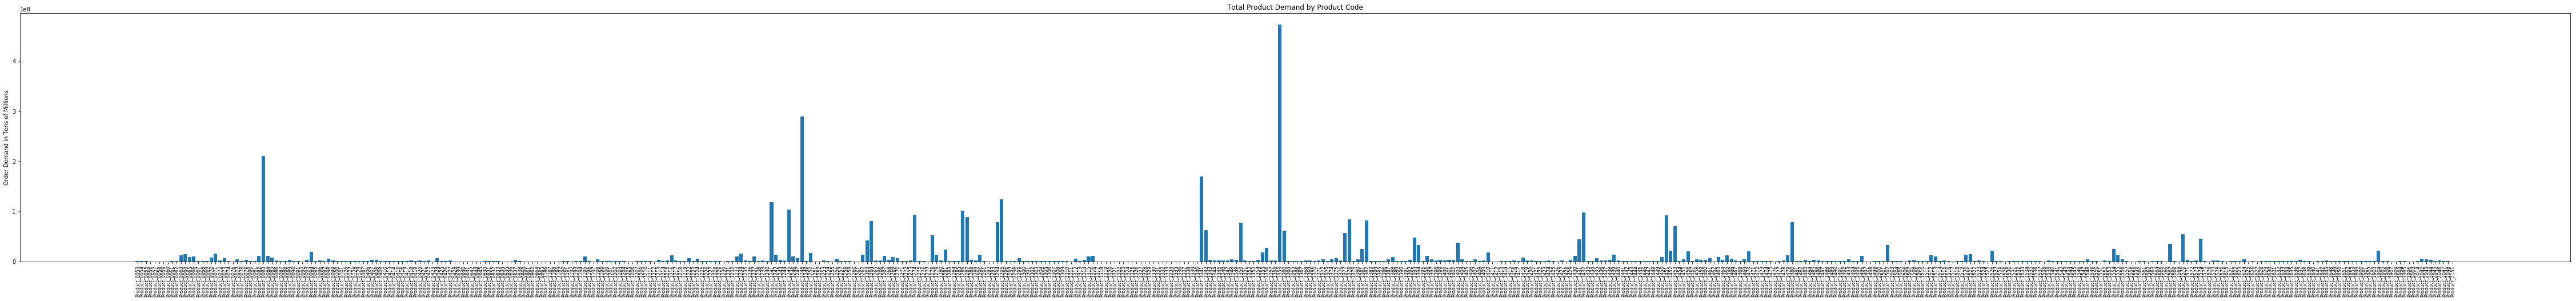

In [ ]:
cat_19 = vs_df.copy() #Create vs_df copy
cat_19 = cat_19[cat_19["Product_Category"] == "Category_019"] # Selects only Category_019's values
cat_19_demand = pd.pivot_table(cat_19,index=["Product_Code"],values=["Order_Demand"],aggfunc=np.sum) #Creates a pivot table with index of Product_Code, Values of the summation of Order_Demand
fig, ax = plt.subplots(figsize=(80,8))
ax.bar(cat_19_demand.index, height=cat_19_demand['Order_Demand']);
ax.set_ylabel('Order Demand in Tens of Millions');
ax.set_xticklabels(cat_19_demand.index, rotation = 90, fontsize = 8);
ax.set_title('Total Product Demand by Product Code');

We can see that there are products with large values but they are dispersed. Lets sort these values.

In [ ]:
#sort values by Order_Demand, desc
cat_19_demand_sorted = cat_19_demand.reindex(cat_19_demand.sort_values('Order_Demand', ascending=False).index) #reindexes the pivot table by Descending Order_Demand

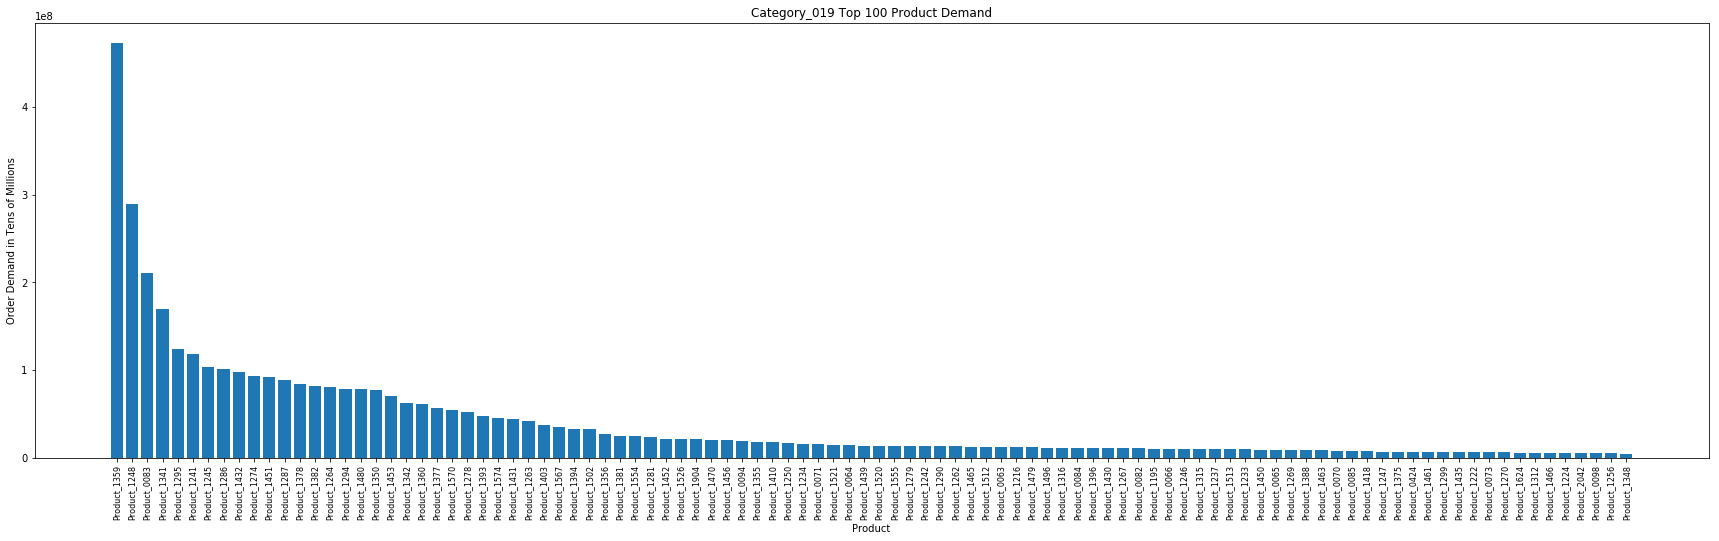

In [ ]:
top_100 = cat_19_demand_sorted.head(100) #gets top 100 order_deman in category_019
fig, ax = plt.subplots(figsize=(30,8))
ax.bar(top_100.index, height=top_100['Order_Demand']);
ax.set_ylabel('Order Demand in Tens of Millions');
ax.set_xlabel('Product');
ax.set_xticklabels(top_100.index, rotation = 90, fontsize = 8);
ax.set_title('Category_019 Top 100 Product Demand');

We can see that Product_1359 has the most demand followed by Product_1248 and Product_1341. Lets See the Top 10.

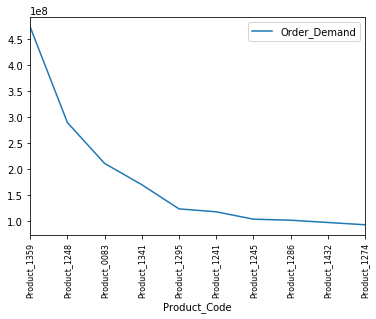

In [ ]:
ax = top_100.head(10).plot()
ax.set_xticklabels(top_100.head(10).index, rotation = 90, fontsize = 8);


In [ ]:
top_100.head(10)

,Order_Demand
Product_Code,
Product_1359,472474000
Product_1248,289117000
Product_0083,210651000
Product_1341,169777000
Product_1295,123303000
Product_1241,117741000
Product_1245,103537000
Product_1286,101566400
Product_1432,97207000


In [ ]:
print(f"We can now see that Product_1359 had a demand of {top_100.head(10).iloc[0]['Order_Demand']:,} and the second most demanded product had a demand of {top_100.head(10).iloc[1]['Order_Demand']:,} having a difference of {top_100.head(10).iloc[1]['Order_Demand']/top_100.head(10).iloc[0]['Order_Demand']:.2f}%")

We can now see that Product_1359 had a demand of 472,474,000 and the second most demanded product had a demand of 289,117,000 having a difference of 0.61%


There we can see that there is 8 products that had a demand greater than 100 million.  
Lets get the monthly demand of the top 5 products.

In [ ]:
products = top_100.head(5).index.to_list()
cat_19_top_5 = cat_19[cat_19['Product_Code'].isin(products)]

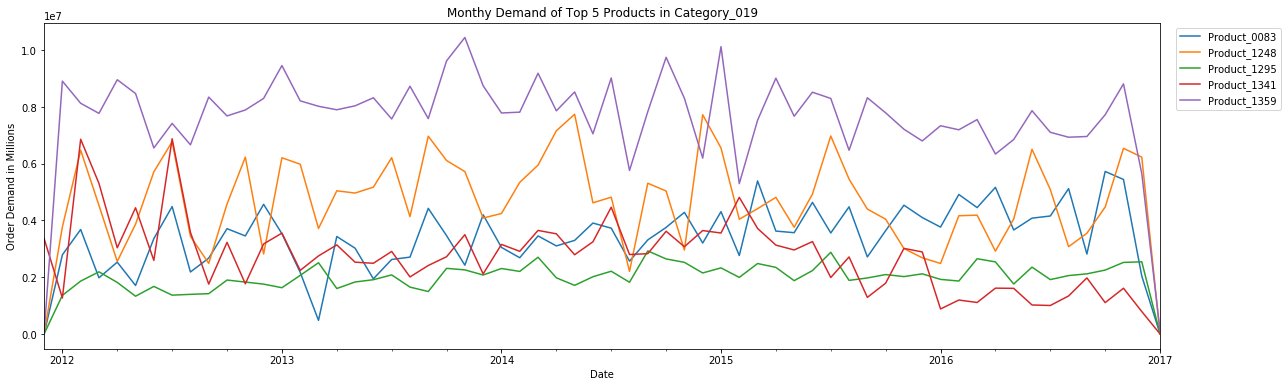

In [ ]:
cat_19_top_5_demand = pd.pivot_table(cat_19_top_5,index=["Date"],values=["Order_Demand"],columns=["Product_Code"],aggfunc=np.sum)
cat_19_top_5_demand.columns = cat_19_top_5_demand.columns.droplevel(0)
cat_19_top_5_demand = cat_19_top_5_demand.resample('M').sum() # Resampling the data on monthly basis 
cat_19_top_5_demand.index.freq = "M" # Setting datetime frequency to Month
ax = cat_19_top_5_demand.plot(figsize = (20,6))
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left') #adjusts the legend outside the graph
ax.set_ylabel('Order Demand in Millions')
ax.set_title('Monthy Demand of Top 5 Products in Category_019');
# ax.set_ylim(0, 90000000)

### Q2: What are the top products across all product categories?

In [ ]:
# Create a pivot_table from the visual dataframe with product_code, and summation of order_demand
top_demand = pd.pivot_table(vs_df,index=["Product_Code"],values=["Order_Demand"],aggfunc=np.sum)
# Reindex with sorted values in descending order
top_demand = top_demand.reindex(top_demand.sort_values('Order_Demand', ascending=False).index)
# Get the top 25
top_25_demand = top_demand.head(25)
cats = [] # array to hold the Product_Category
# appends the associated product_category to the cats array
for i in top_25_demand.index.tolist():
    cats.append(vs_df[vs_df['Product_Code'] == i]['Product_Category'].iloc[0])

In [ ]:
# Set the Category field to cats
top_25_demand['Category'] = cats


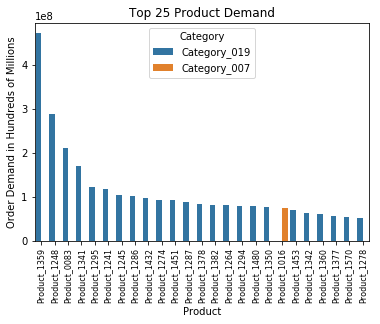

In [ ]:
# Plot the data
ax = sns.barplot(data=top_25_demand, x=top_25_demand.index, y='Order_Demand', hue='Category')
ax.set_ylabel('Order Demand in Hundreds of Millions');
ax.set_xlabel('Product');
ax.set_xticklabels(top_25_demand.index, rotation = 90, fontsize = 8);
ax.set_title('Top 25 Product Demand');

### As we can see in the top 25 products, **Category_019** dominates the order demand. Additionally, **Product_1016** in **Category_007** lands a spot in top 25 with number 19.

### Q3: Is there Seasonal Trends?

In [ ]:
# plots yearly data
def yearly_plot(start, end, data):
    '''
    start: Year in which the graphing should start
    end: Year in which the graphing should end
    data: Dataframe to be graphed
    '''
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
    fig.tight_layout(pad=3.0)
    c, r = 0,0
    for i in range(start, end):
        if c == 4:
            c = 0
            r = 1
        dfyr = data[data['Date:year'] == i]
        df_demand_by_month = pd.DataFrame(columns=['month', 'demand'])
        for i in range(1, 13):
            df_demand_by_month = df_demand_by_month.append({'month': i, 'demand': dfyr[dfyr['Date:month'] == i]['Order_Demand'].sum() }, ignore_index=True)

        df_demand_by_month.plot('month', 'demand', ax=ax[r][c])
        c += 1

    for i, x in enumerate(ax.ravel()): 

        x.set_title(start)
        start +=1



#### Monthly Total Demand by year

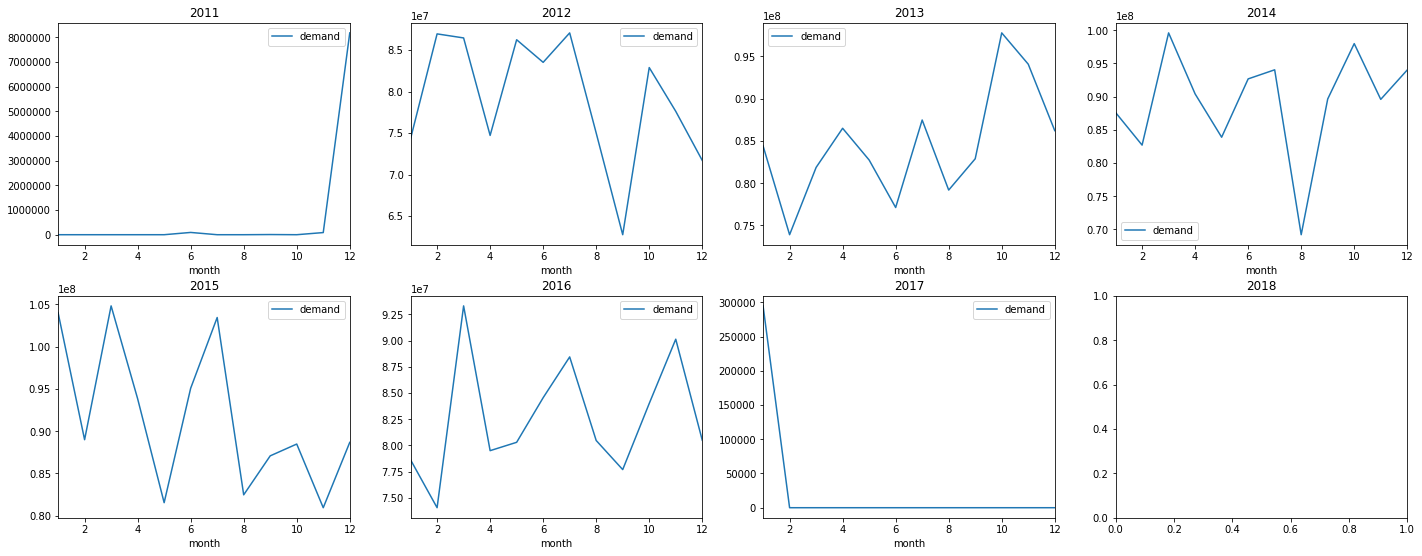

In [ ]:
%matplotlib inline
yearly_plot(2011, 2018, vs_df)

We can observe that there are dips in months 4 (April) and 8 (August). This does not tell us much besides a dip from month 7 to 8.  
Lets observe the Mean

In [ ]:
val = {} #holds the dictionary
#Avoiding 2011/2017 as they were unsual years
for i in range(2012,2017):
    year = vs_df[(vs_df['Date:year'] == i)]
    val[i] = {}
    for j in range(1,13):
        val[i][j] = np.round(year[year['Date:month'] == j]['Order_Demand'].mean())
    
means = pd.DataFrame().from_dict(val)
means

,2012,2013,2014,2015,2016
1,4761.0,5073.0,4863.0,5702.0,5417.0
2,4798.0,4317.0,4540.0,4912.0,4592.0
3,4648.0,4705.0,5019.0,5482.0,5399.0
4,4504.0,4891.0,5000.0,5331.0,5223.0
5,5069.0,4652.0,5041.0,5236.0,5543.0
6,4939.0,4696.0,5217.0,5163.0,5150.0
7,4914.0,4583.0,4983.0,5409.0,5773.0
8,4548.0,4753.0,4319.0,5318.0,5248.0
9,4019.0,4375.0,4725.0,5228.0,5053.0
10,4477.0,3983.0,5003.0,4975.0,5188.0


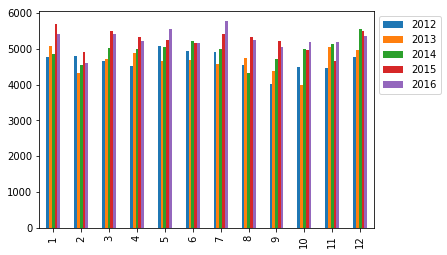

In [ ]:
ax = means.plot.bar()
ax.legend(bbox_to_anchor=(1.0, 1.0))

#### This bargraph kind of shows us a bit of a wave pattern going on. Lets compute the mean by month over the 5 years.

In [ ]:
means['mean'] = means.mean(axis=1)

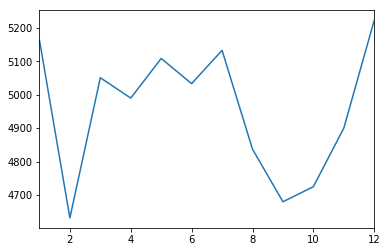

In [ ]:
means['mean'].plot.line()

### There seems to be a decrease in demand post winter holidays, increase in demand in the Spring/Summer months, a decrease in the Fall, and increase during the winter holidays.
This means that there is some kind of seasonal demand.